In [1]:
# Se requiere Python ≥ 3.5
import sys;
assert sys.version_info >= (3, 5)

# Se requiere Scikit-Learn ≥ 0.20
import sklearn;
assert sklearn.__version__ >= "0.20"

# Otros imports
import numpy as np;
import os;

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
housing_path="data"
image_path = os.path.join(housing_path, "california.png")

def load_housing_data(housing_url=HOUSING_URL, housing_path='data'):
    # Si el fichero no existe lo baja y lo descomprime
    csv_path = os.path.join(housing_path, "housing.csv")
    if not os.path.exists(csv_path):
        # Crea el directorio para descomprimir si no existe
        if not os.path.isdir(housing_path):
            os.makedirs(housing_path)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        urllib.request.urlretrieve(housing_url, tgz_path)
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()
    # Comprueba si tenemos california.png y si no la descarga
    if not os.path.exists(image_path):
        print("Downloading", filename)
        url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
        urllib.request.urlretrieve(url, os.path.join(images_path, filename))
    return pd.read_csv(csv_path)

'\nimport tarfile;\nimport urllib.request;\n\nDOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"\nHOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"\nHOUSING_PATH = os.path.join("datasets", "housing")\n# esta función descarga y descomprime los datos desde una url a un directorio\ndef fetch_housing_data(housing_url=HOUSING_URL, housing_path=\'data/\'):\n    if not os.path.isdir(housing_path):\n        os.makedirs(housing_path)\n    tgz_path = os.path.join(housing_path, "housing.tgz")\n    urllib.request.urlretrieve(housing_url, tgz_path)\n    housing_tgz = tarfile.open(tgz_path)\n    housing_tgz.extractall(path=housing_path)\n    housing_tgz.close()\n# Y llamamos a la función recién creada para descargar los datos\nfetch_housing_data()\n'

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Hacemos el bucketing

In [4]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
                               labels=[1, 2, 3, 4, 5])

Particionamos en train set y test set

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

# Eliminamos la columna income_cat en las particiones creadas
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Definimos la función que crea atributos compuestos

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the column indices
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


Definimos la pipeline para atributos numéricos

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])


Separamos la columna de objetivos

Aplicamos el preprocesado completo a las variables independientes

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder;

housing_num = strat_train_set.drop(["ocean_proximity", "median_house_value"], axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
y_train = strat_train_set["median_house_value"].copy()
X_train = full_pipeline.fit_transform(strat_train_set)
X_train.shape


(16512, 16)

# Seleccionar y entrenar el modelo

## Entrenando y evaluando el modelo de **train_set**

**Regresión lineal multivariable**

In [110]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Vamos a probar el pipeline completo en unos cuantos datos de entrenamiento

In [ ]:
some_data_prepared = X_train[:5]
print("Predictions:", lin_reg.predict(some_data_prepared))
some_labels = y_train[:5]
print("Labels:", list(some_labels))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [111]:
from sklearn.metrics import mean_squared_error

predictions = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(68627.87390018745)

**Note**: since Scikit-Learn 0.22, you can get the RMSE directly by calling the `mean_squared_error()` function with `squared=False`.

In [112]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_train, predictions)
lin_mae

49438.66860915802

**Decision Tree**

In [79]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [80]:
predictions = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(0.0)

**Error 0!!!**

Pero no cantemos victoria. Estamos evaluando contra el mismo dataset que hemos empleado para entrenar el modelo. 

Esto es, básicamente, hacer trampa.

## Usando la Cross-Validation

Vamos a usar un medio de evaluación del modelo sin usar -aún- el testset.

In [81]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [82]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
Mean: 71629.89009727491
Standard deviation: 2914.035468468928


In [83]:
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180694


**Random Forest**

In [113]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [85]:
predictions = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

np.float64(18650.698705770003)

In [114]:
forest_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
Mean: 50435.58092066179
Standard deviation: 2203.3381412764606


El mejor de los que hemos probado.

**Support Vector Regression**

In [87]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(X_train, y_train)
predictions = svm_reg.predict(X_train)
svm_mse = mean_squared_error(y_train, predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

np.float64(111095.06635291968)

# Fine-Tune Your Model

## Grid Search

In [115]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

,estimator,RandomForestR...ndom_state=42)
,param_grid,"[{'max_features': [2, 4, ...], 'n_estimators': [3, 10, ...]}, {'bootstrap': [False], 'max_features': [2, 3, ...], 'n_estimators': [3, 10]}]"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,30


The best hyperparameter combination found:

In [116]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [93]:
grid_search.best_estimator_

,n_estimators,30
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,8
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Let's look at the score of each hyperparameter combination tested during the grid search:

In [117]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In [104]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.179891,0.040543,0.005763,0.000467,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.119912e+09,-3.723465e+09,...,-4.082592e+09,1.867375e+08,18,-1.155630e+09,-1.089726e+09,-1.153843e+09,-1.118149e+09,-1.093446e+09,-1.122159e+09,2.834288e+07
1,0.445395,0.004021,0.012204,0.000154,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.973521e+09,-2.810319e+09,...,-3.015803e+09,1.139808e+08,11,-5.982947e+08,-5.904781e+08,-6.123850e+08,-5.727681e+08,-5.905210e+08,-5.928894e+08,1.284978e+07
2,1.323670,0.095860,0.034250,0.001602,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.801229e+09,-2.671474e+09,...,-2.796915e+09,7.980892e+07,9,-4.412567e+08,-4.326398e+08,-4.553722e+08,-4.320746e+08,-4.311606e+08,-4.385008e+08,9.184397e+06
3,0.262762,0.018763,0.005063,0.000237,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.528743e+09,-3.490303e+09,...,-3.609050e+09,1.375683e+08,16,-9.782368e+08,-9.806455e+08,-1.003780e+09,-1.016515e+09,-1.011270e+09,-9.980896e+08,1.577372e+07
4,0.827901,0.025635,0.012966,0.001108,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.742620e+09,-2.609311e+09,...,-2.755726e+09,1.182604e+08,7,-5.063215e+08,-5.257983e+08,-5.081984e+08,-5.174405e+08,-5.282066e+08,-5.171931e+08,8.882622e+06
5,2.354922,0.145484,0.035348,0.004149,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.522176e+09,-2.440241e+09,...,-2.518759e+09,8.488084e+07,3,-3.776568e+08,-3.902106e+08,-3.885042e+08,-3.830866e+08,-3.894779e+08,-3.857872e+08,4.774229e+06
6,0.331863,0.048277,0.004770,0.000426,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.362127e+09,-3.311863e+09,...,-3.371513e+09,1.378086e+08,13,-8.909397e+08,-9.583733e+08,-9.000201e+08,-8.964731e+08,-9.151927e+08,-9.121998e+08,2.444837e+07
7,0.976050,0.005590,0.011904,0.000138,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.622099e+09,-2.669655e+09,...,-2.654240e+09,6.967978e+07,5,-4.939906e+08,-5.145996e+08,-5.023512e+08,-4.959467e+08,-5.147087e+08,-5.043194e+08,8.880106e+06
8,3.387395,0.125691,0.039110,0.003590,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.446142e+09,-2.446594e+09,...,-2.496981e+09,7.357046e+07,2,-3.760968e+08,-3.876636e+08,-3.875307e+08,-3.760938e+08,-3.861056e+08,-3.826981e+08,5.418747e+06
9,0.396670,0.011195,0.004688,0.000612,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.590333e+09,-3.232664e+09,...,-3.468718e+09,1.293758e+08,14,-9.505012e+08,-9.166119e+08,-9.033910e+08,-9.070642e+08,-9.459386e+08,-9.247014e+08,1.973471e+07


## Randomized Search

In [96]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_features': <scipy.stats....x7cac2253a090>, 'n_estimators': <scipy.stats....x7cac2251f530>}"
,n_iter,10
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [97]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


## Analyze the Best Models and Their Errors

In [118]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03])

In [119]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.3790092248170967), 'median_income'),
 (np.float64(0.16570630316895876), 'INLAND'),
 (np.float64(0.10703132208204354), 'pop_per_hhold'),
 (np.float64(0.06965425227942929), 'longitude'),
 (np.float64(0.0604213840080722), 'latitude'),
 (np.float64(0.054778915018283726), 'rooms_per_hhold'),
 (np.float64(0.048203121338269206), 'bedrooms_per_room'),
 (np.float64(0.04218822024391753), 'housing_median_age'),
 (np.float64(0.015849114744428634), 'population'),
 (np.float64(0.015554529490469328), 'total_bedrooms'),
 (np.float64(0.01524505568840977), 'total_rooms'),
 (np.float64(0.014934655161887776), 'households'),
 (np.float64(0.006792660074259966), '<1H OCEAN'),
 (np.float64(0.0030281610628962747), 'NEAR OCEAN'),
 (np.float64(0.0015247327555504937), 'NEAR BAY'),
 (np.float64(7.834806602687504e-05), 'ISLAND')]

## Evaluando el modelo con el test set

Quizá habría que repetir todo el proceso de limpieza y adaptación que hicimos anteriormente con el train set. En nuestro caso, sólo un campo se nos quedó olvidado.

In [120]:
y_test = strat_test_set["median_house_value"].copy()
X_test = strat_test_set.drop("median_house_value", axis=1)
# Al lorito, no usamos fit_transform para que reutilice las medias y stdevs calculadas
X_test = full_pipeline.transform(X_test)

In [122]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

np.float64(47873.26095812988)

We can compute a 95% confidence interval for the test RMSE:

In [123]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45893.36082829, 49774.46796717])

We could compute the interval manually like this:

In [124]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(np.float64(45893.360828285535), np.float64(49774.46796717361))

Alternatively, we could use a z-scores rather than t-scores:

In [125]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(np.float64(45893.9540110131), np.float64(49773.921030650374))

# Extra material

## A full pipeline with both preparation and prediction

In [136]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(strat_train_set, y_train)
some_data = strat_train_set.iloc[:5]
full_pipeline_with_predictor.predict(some_data)

array([ 85657.90192014, 305492.60737488, 152056.46122456, 186095.70946094,
       244550.67966089])

## Model persistence using joblib

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

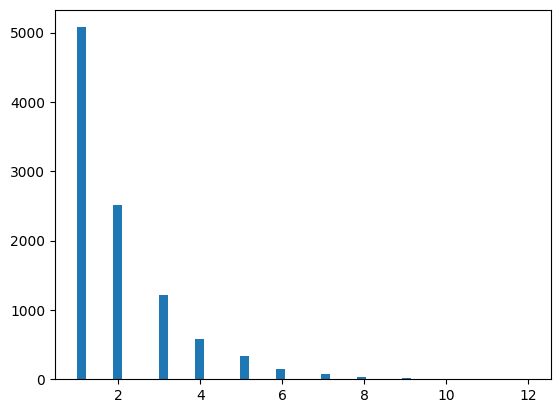

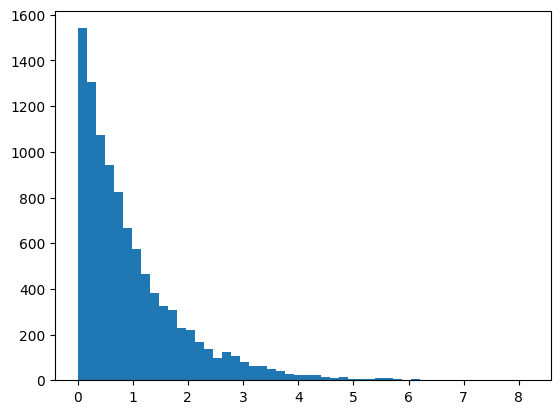

In [133]:
from scipy.stats import geom, expon
import matplotlib as mpl;
import matplotlib.pyplot as plt;
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()